## Imports

In [1]:
## Standard libraries
import sys
import os
import numpy as np
import random
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

## Donwload the pretrained models

In [2]:
from torchvision.models import vgg11, VGG11_Weights
from torchvision.models import vgg11_bn, VGG11_BN_Weights
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models import densenet121, DenseNet121_Weights
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# VGG11 weights with accuracy 69.02%
m_vgg11 = vgg11(weights=VGG11_Weights.IMAGENET1K_V1)
# VGG11 with batch norm weights with accuracy 70.37%
m_vgg11_bn = vgg11_bn(weights=VGG11_BN_Weights.IMAGENET1K_V1)
# ResNet18 with accuracy 69.758%
m_resnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# ResNet34 with accuracy 73.314%
m_resnet34 = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
# DenseNet121 with accuracy 74.434%
m_densenet121 = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
# MobileNet_V3_Small with accuracy 67.668%
m_mobilenet_v3_small = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

## Set seed for reproducibility and check the available devices

In [3]:
# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

if(torch.cuda.is_available()):
    print("Using GPU: " + torch.cuda.get_device_name(device))
else:
    print("Using CPU")

Using GPU: Tesla T4


In [4]:
!nvidia-smi

Wed Nov 30 18:03:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
print(torch.cuda.memory_allocated())

0


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/Shareddrives/Colab')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
# Path to the folder where the plots are saved
PLOT_PATH = "./saved_plots/assignment2/part1"

# Create plot path if it doesn't exist yet
os.makedirs(PLOT_PATH, exist_ok=True)

## Question 1.1 (a) - Inference Time

In [8]:
def calculate_inference(device, model, input, num_passes, requires_grad=False):
  # set the model to evaluation mode
  model.eval()
  # put the model and the input on the GPU
  model.to(device)
  input = input.to(device)
  # create event markers
  start, stop = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
  # initialize a list to collect timings
  all_times = []

  # GPU warm up
  sample = input[0].unsqueeze(0)
  for _ in range(10):
    _ = model(sample)
  
  # measure inference time
  with torch.set_grad_enabled(requires_grad):
    for i in range(num_passes):
      # take a sample image from the input batch
      sample = input[i].unsqueeze(0)
      # mark the start and the end of one pass
      start.record()
      _ = model(sample)
      stop.record()
      # wait for the cores to synchronize
      torch.cuda.synchronize()
      curr_time = start.elapsed_time(stop) # in ms
      all_times.append(curr_time)

  # calculate mean time for K passes
  mean_time = sum(all_times) / num_passes

  # Clear memory and detach from GPU
  input = input.detach()
  sample = sample.detach()
  model.to(torch.device("cpu"))
  torch.cuda.empty_cache()

  return mean_time

In [9]:
models_list = [m_vgg11, m_vgg11_bn, m_resnet18, m_resnet34, m_densenet121, m_mobilenet_v3_small]
names = ["vgg11", "vgg11_bn", "resnet18", "resnet34", "densenet121", "mobilenet_v3_small"]
accuracies = [69.02, 70.37, 69.758, 73.314, 74.434, 67.668]  # in %
num_params = [132.9, 132.9, 11.7, 21.8, 8.0, 2.5]  # in millions

# number of forward passes to do
num_iterations = 300
# create a sample dummy input of 300 3x224x224 images, 1 for each forward pass
dummy_input = torch.randn(300, 3, 224, 224, dtype=torch.float)

In [10]:
# create a dictionary to collect the results with no grad
results = {}

for i, model in enumerate(models_list):
  inference_time = calculate_inference(device, model, dummy_input, num_iterations)
  results[names[i]] = inference_time

print(results)

{'vgg11': 6.861065592765808, 'vgg11_bn': 6.958702843983968, 'resnet18': 4.409688860575358, 'resnet34': 8.144806175231933, 'densenet121': 21.919635206858317, 'mobilenet_v3_small': 6.9068319034576415}


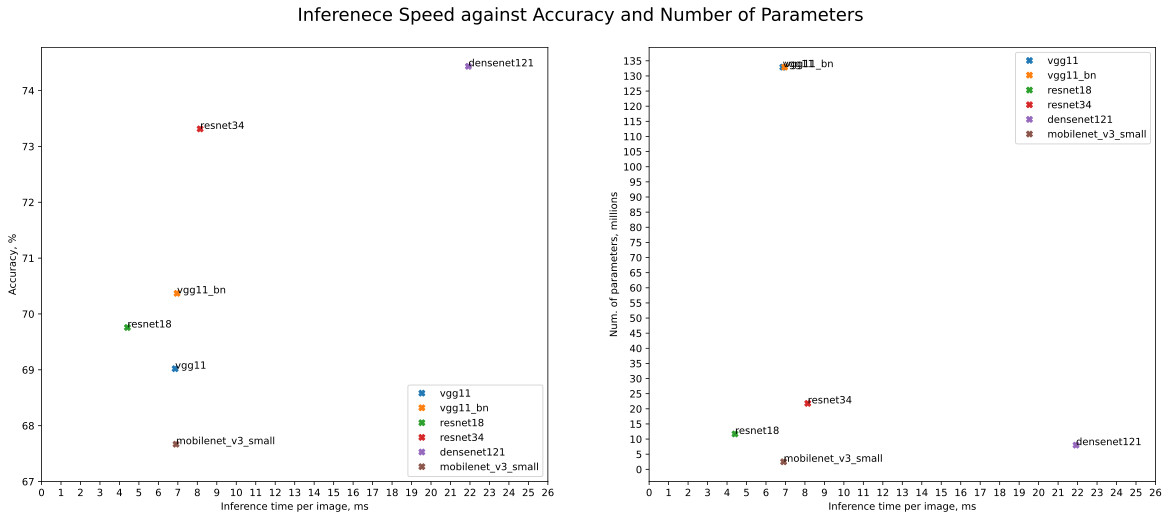

In [11]:
fig = plt.figure(figsize=(20, 8))
plt.subplots_adjust(hspace=0.3)
fig.suptitle('Inferenece Speed against Accuracy and Number of Parameters', fontsize=18, y=0.95)

ax = fig.add_subplot(1, 2, 1)
for i, (model_name, time) in enumerate(results.items()):
  plt.plot(time, accuracies[i], 'X', markersize=6, label=f'{model_name}')
  plt.annotate(model_name, (time, accuracies[i]))

plt.yticks(np.arange(round(min(accuracies))-1, round(max(accuracies))+1, 1))
plt.xticks(np.arange(0, round(max(results.values()))+5, 1))

ax.set_xlabel('Inference time per image, ms') 
ax.set_ylabel('Accuracy, %')
ax.legend(loc='lower right')

ax1 = fig.add_subplot(1, 2, 2)
for i, (model_name, time) in enumerate(results.items()):
  plt.plot(time, num_params[i], 'X', markersize=6, label=f'{model_name}')
  plt.annotate(model_name, (time, num_params[i]))

plt.yticks(np.arange(0, max(num_params)+5, 5))
plt.xticks(np.arange(0, round(max(results.values()))+5, 1))

ax1.set_xlabel('Inference time per image, ms') 
ax1.set_ylabel('Num. of parameters, millions')
ax1.legend(loc='upper right')

plt.savefig(f"{PLOT_PATH}/q1.1a.png", bbox_inches='tight')
plt.show()

## Question 1.1 (b)

In [12]:
results_grad = {}

for i, model in enumerate(models_list):
  inference_time = calculate_inference(device, model, dummy_input, num_iterations, True)
  results_grad[names[i]] = inference_time

print(results_grad)

{'vgg11': 6.81426975886027, 'vgg11_bn': 7.06974666595459, 'resnet18': 4.639045329093933, 'resnet34': 8.62928201675415, 'densenet121': 24.035445079803466, 'mobilenet_v3_small': 7.930100348790487}


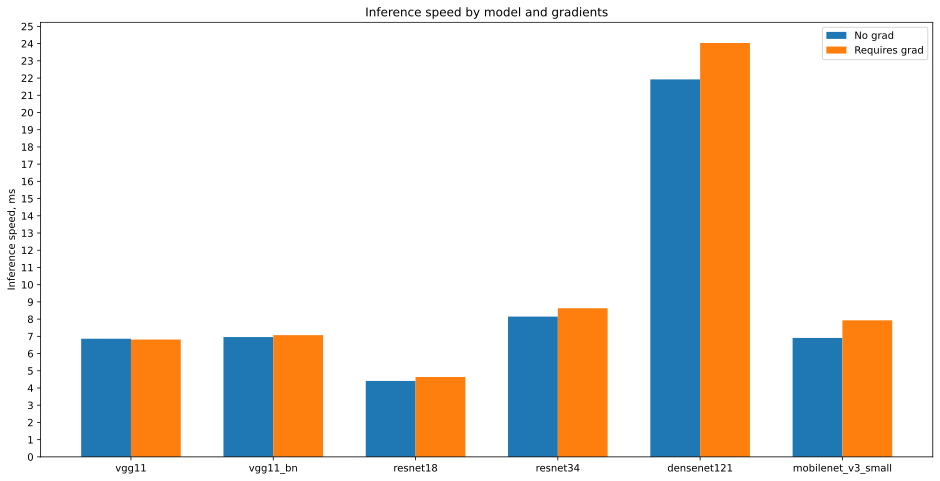

In [13]:
labels = list(results.keys())
x = np.arange(len(labels))
width = 0.35

no_grad = list(results.values())
with_grad = list(results_grad.values())

fig = plt.figure(figsize=(16, 8))
plt.bar(x - width/2, no_grad, width, label='No grad')
plt.bar(x + width/2, with_grad, width, label='Requires grad')

plt.ylabel('Inference speed, ms')
plt.title('Inference speed by model and gradients')
plt.xticks(x, labels)
plt.yticks(np.arange(0, round(max(with_grad))+2, 1))
plt.legend()

plt.savefig(f"{PLOT_PATH}/q1.1b.png", bbox_inches='tight')
plt.show()

## Question 1.1 (c)

In [14]:
def calculate_memory(device, model, input, requires_grad=False):
  # set the model to evaluation mode
  model.eval()
  # put the model and the input on the GPU
  model.to(device)
  input = input.to(device)
  
  # measure inference time
  with torch.set_grad_enabled(requires_grad):
    # mark the start and the end of one pass
    mem_before = torch.cuda.memory_allocated()
    scores = model(input)
    mem_after = torch.cuda.memory_allocated()
    # calculate the difference
    mem = mem_after - mem_before # in bytes
    mem = mem * 1e-6  # in megabytes

  # Clear memory and detach from GPU
  input = input.detach()
  model.to(torch.device("cpu"))
  torch.cuda.empty_cache()

  return mem

In [15]:
# make a batch with size 64
dummy_batch = torch.randn(64, 3, 224, 224, dtype=torch.float)

mem_no_grad = {}
mem_with_grad = {}

for i, model in enumerate(models_list):
  no_grad = calculate_memory(device, model, dummy_batch, False)
  with_grad = calculate_memory(device, model, dummy_batch, True)

  mem_no_grad[names[i]] = no_grad
  mem_with_grad[names[i]] = with_grad

print(mem_no_grad)
print()
print(mem_with_grad)

{'vgg11': 0.256, 'vgg11_bn': 0.256, 'resnet18': 0.256, 'resnet34': 0.256, 'densenet121': 0.256, 'mobilenet_v3_small': 0.256}

{'vgg11': 3087.263744, 'vgg11_bn': 4988.332031999999, 'resnet18': 1390.667776, 'resnet34': 2037.1148799999999, 'densenet121': 8345.987072, 'mobilenet_v3_small': 1013.1374079999999}


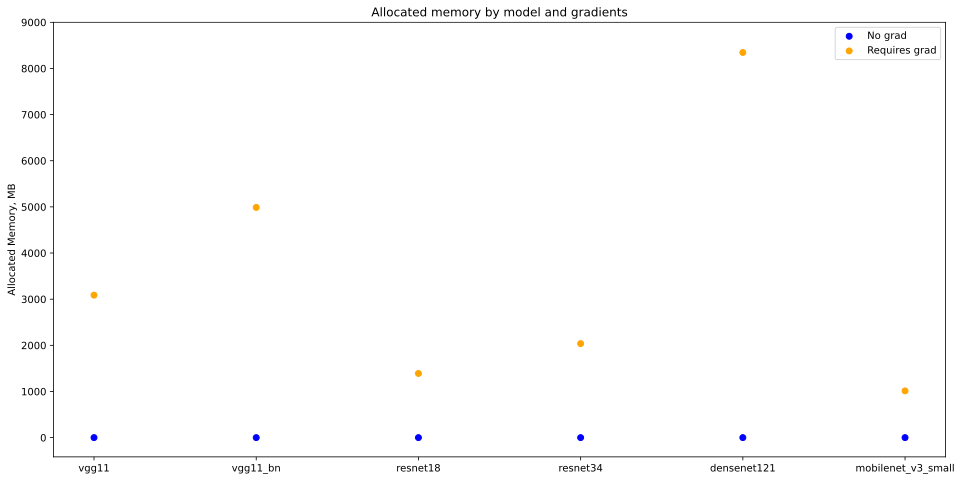

In [18]:
labels = list(mem_no_grad.keys())
x = np.arange(len(labels))
width = 0.35

no_grad = list(mem_no_grad.values())
with_grad = list(mem_with_grad.values())

fig = plt.figure(figsize=(16, 8))
plt.scatter(x, no_grad, color='blue', label='No grad')
plt.scatter(x, with_grad, color='orange', label='Requires grad')

plt.ylabel('Allocated Memory, MB')
plt.title('Allocated memory by model and gradients')
plt.xticks(x, labels)
plt.yticks(np.arange(0, round(max(with_grad))+1000, 1000))
plt.legend()

plt.savefig(f"{PLOT_PATH}/q1.1c.png", bbox_inches='tight')
plt.show()